<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Neural Networks (NN) - MLP Modeling 
</p>

In [26]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and training
import tensorflow as tf                          # For deep learning framework
from keras.models import Sequential              # For creating sequential models
from keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU  # Layers for building neural networks
from keras.regularizers import l2               # For L2 regularization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # For training optimization

# Libraries for evaluation and preprocessing
from sklearn.metrics import (                   # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.preprocessing import StandardScaler # For standardizing features
from sklearn.model_selection import KFold, train_test_split # For cross-validation and splitting data

# Set seed for reproducibility
GLOBAL_SEED = 50
np.random.seed(GLOBAL_SEED)                      # Seed for NumPy
tf.random.set_seed(GLOBAL_SEED)                  # Seed for TensorFlow

In [27]:
# Load dataset and display basic information

# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    # Exit the notebook if the dataset is not found
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()

# Display the first five rows for a quick preview
print("\nFirst Five Rows of the Dataset:")
display(df.head())

Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656317 entries, 0 to 656316
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         656317 non-null  object 
 1   device_id    656317 non-null  object 
 2   co2          656317 non-null  float64
 3   humidity     656317 non-null  float64
 4   pm25         656317 non-null  float64
 5   pressure     656317 non-null  float64
 6   temperature  656317 non-null  float64
 7   rssi         656317 non-null  float64
 8   snr          656317 non-null  float64
 9   SF           656317 non-null  int64  
 10  frequency    656317 non-null  float64
 11  f_count      656317 non-null  float64
 12  p_count      656317 non-null  float64
 13  toa          656317 non-null  float64
 14  distance     656317 non-null  int64  
 15  c_walls      656317 non-null  int64  
 16  w_walls      656317 non-null  int64  
 17  exp_pl       656

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:02:08.387851+00:00,ED0,539.0,49.34,0.39,299.69,24.57,-48.0,8.5,9,867.5,82.0,109.0,0.246784,10,0,0,65.4,-57.073822,-48.573822
1,2024-09-26 11:03:08.309590+00:00,ED0,540.0,49.33,0.80,299.77,24.59,-48.0,12.8,8,867.3,83.0,110.0,0.133632,10,0,0,65.4,-61.022142,-48.222142
2,2024-09-26 11:04:08.368448+00:00,ED0,537.0,49.28,0.71,299.70,24.62,-48.0,8.0,8,868.5,84.0,111.0,0.133632,10,0,0,65.4,-56.638920,-48.638920
3,2024-09-26 11:05:08.405529+00:00,ED0,537.0,49.34,0.56,299.69,24.63,-49.0,11.0,8,867.9,85.0,112.0,0.133632,10,0,0,66.4,-60.331956,-49.331956
4,2024-09-26 11:06:08.455112+00:00,ED0,534.0,49.28,0.60,299.73,24.64,-46.0,9.2,8,867.5,86.0,113.0,0.133632,10,0,0,63.4,-55.693058,-46.493058


In [28]:
# Extract necessary columns and perform train-test split with normalization

# Define feature columns and target
feature_columns = [
    'distance', 
    'frequency', 
    'c_walls', 
    'w_walls', 
    'co2', 
    'humidity', 
    'pm25', 
    'pressure', 
    'temperature', 
    'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist in the dataframe
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, 
    PL_all, 
    test_size=0.2, 
    random_state=GLOBAL_SEED
)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_all_scaled = scaler.fit_transform(X_train_all)

# Transform the test data
X_test_all_scaled = scaler.transform(X_test_all)

print("\nTrain-test split and feature scaling completed...\n")


Train-test split and feature scaling completed...



In [29]:
def create_ann_model(input_dim):
    """Creates an enhanced ANN model for regression with regularization and improved 
    architecture."""
    model = Sequential()

    # Explicit Input layer
    model.add(Input(shape=(input_dim,)))  
    
    # First Hidden Layer
    model.add(Dense(4, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(negative_slope=0.1)) 
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second Hidden Layer
    
    # Output layer for regression
    model.add(Dense(1, activation='linear'))  

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Instantiate the model
input_dim = X_train_all_scaled.shape[1]
model = create_ann_model(input_dim)
model.summary()

# Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increased patience
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train the model with Callbacks
history = model.fit(
    X_train_all_scaled,
    PL_train_all,
    validation_split=0.2,
    epochs=500,  # Increased epochs to allow more training
    batch_size=128,  # Reduced batch size for more frequent updates
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

print("\nModel training completed...\n")

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (260.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 8 (32.00 B)

Epoch 1/500
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 6458.8232 - mae: 77.6990 - val_loss: 615.9286 - val_mae: 23.6128 - learning_rate: 0.0010
Epoch 2/500
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 875.8541 - mae: 23.0278 - val_loss: 123.8267 - val_mae: 8.5267 - learning_rate: 0.0010
Epoch 3/500
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 769.3585 - mae: 21.1623 - val_loss: 117.2809 - val_mae: 8.3122 - learning_rate: 0.0010
Epoch 4/500
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 725.1295 - mae: 20.5334 - val_loss: 109.0088 - val_mae: 7.9721 - learning_rate: 0.0010
Epoch 5/500
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 674.4626 - mae: 19.7710 - val_loss: 110.6811 - val_mae: 8.0448 - learning_rate: 0.0010
Epoch 6/500
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 631.7394 - mae: 19.1247 - val_loss: 102.2593 - val_mae: 7.6460 - learning_rate: 0.0010
Epoch 7/500
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 588.7443 - mae: 18.4467 - va

In [30]:
# Evaluate the trained model on training and test data and display metrics in a table

# Evaluate the model on training data
train_loss, train_mae = model.evaluate(X_train_all_scaled, PL_train_all, verbose=0)

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test_all_scaled, PL_test_all, verbose=0)

# Predict path loss for the test set
PL_pred = model.predict(X_test_all_scaled).flatten()

# Calculate additional metrics
rmse_test = np.sqrt(mean_squared_error(PL_test_all, PL_pred))
r2_test = r2_score(PL_test_all, PL_pred)
mape_test = mean_absolute_percentage_error(PL_test_all, PL_pred)
median_ae_test = median_absolute_error(PL_test_all, PL_pred)

# Create a results DataFrame
results = pd.DataFrame({
    'Metric': ['Training Loss (MSE)', 'Training MAE', 
               'Test Loss (MSE)', 'Test MAE', 
               'Test RMSE', 'R² Score', 
               'Test MAPE (%)', 'Test Median AE'],
    'Value': [train_loss, train_mae, 
              test_loss, test_mae, 
              rmse_test, r2_test, 
              mape_test * 100, median_ae_test]
})

# Display the results table
print("\nModel Evaluation Metrics:")
display(results)

4102/4102 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),55.134186
1,Training MAE,5.327254
2,Test Loss (MSE),54.638638
3,Test MAE,5.310789
4,Test RMSE,7.390823
5,R² Score,0.849277
6,Test MAPE (%),6.132167
7,Test Median AE,4.193970


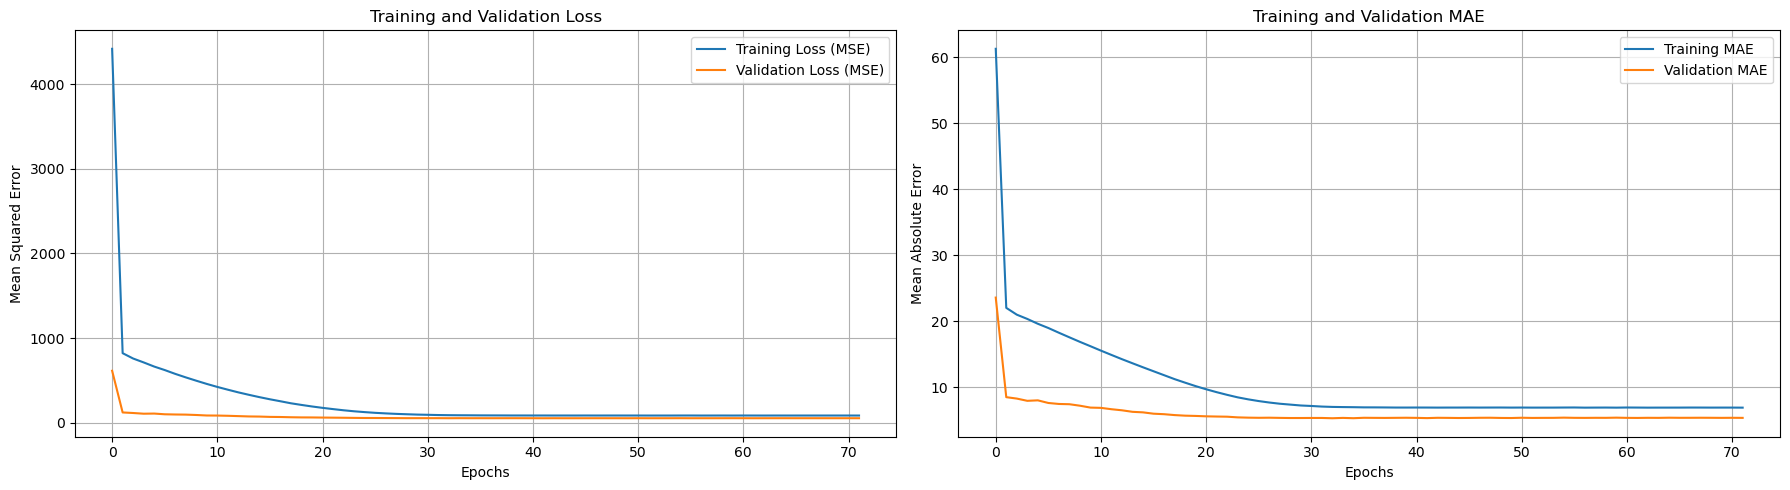

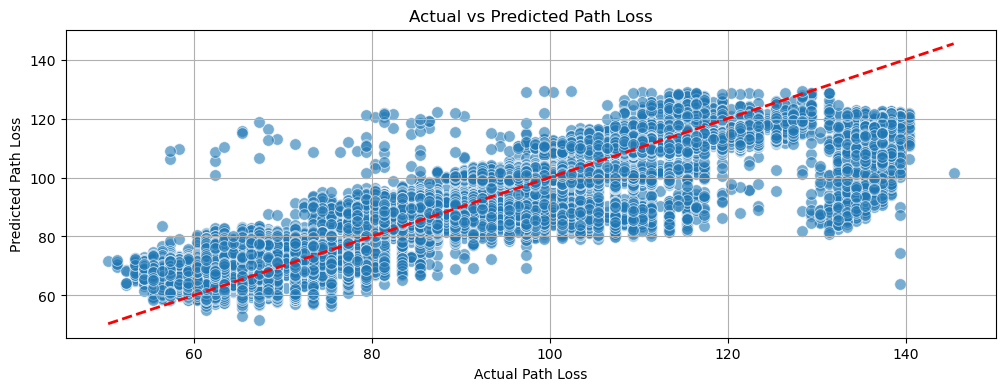

In [31]:
# Visualize training history and model predictions

# Plot training and validation loss
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(12, 4))
sns.scatterplot(x=PL_test_all, y=PL_pred, alpha=0.6, edgecolor='w', s=70)
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss')
plt.grid(True)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Cross-Validation
</p>

In [32]:
# Perform K-Fold Cross-Validation to assess model robustness and display results in a table

# Define K-Fold Cross Validator
kf = KFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)
fold = 1
cv_results_list = []

for train_index, val_index in kf.split(X_train_all_scaled):
    print(f"Training fold {fold}...")
    
    # Split data into training and validation for the current fold
    X_train_fold, X_val_fold = X_train_all_scaled[train_index], X_train_all_scaled[val_index]
    PL_train_fold, PL_val_fold = PL_train_all[train_index], PL_train_all[val_index]
    
    # Create a new instance of the model for each fold
    model = create_ann_model(input_dim)
    
    # Define Callbacks
    early_stop_cv = EarlyStopping(
        monitor='val_loss',
        patience=30,  # Patience can be adjusted as needed
        restore_best_weights=True
    )
    
    reduce_lr_cv = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=0
    )
    
    # Train the model on the current fold
    history_cv = model.fit(
        X_train_fold, 
        PL_train_fold, 
        validation_data=(X_val_fold, PL_val_fold),
        epochs=500, 
        batch_size=128, 
        callbacks=[early_stop_cv, reduce_lr_cv],
        verbose=0  # Set to 1 for detailed output
    )
    
    # Predict path loss for the test set
    PL_pred_cv = model.predict(X_test_all_scaled).flatten()

    # Calculate metrics
    test_loss, test_mae = model.evaluate(X_test_all_scaled, PL_test_all, verbose=0)
    rmse_cv = np.sqrt(mean_squared_error(PL_test_all, PL_pred_cv))
    r2_cv = r2_score(PL_test_all, PL_pred_cv)
    mape_cv = mean_absolute_percentage_error(PL_test_all, PL_pred_cv)
    median_ae_cv = median_absolute_error(PL_test_all, PL_pred_cv)
    
    # Append metrics to the results list
    cv_results_list.append({
        'Fold': fold,
        'Test Loss (MSE)': round(test_loss, 4),
        'Test MAE': round(test_mae, 4),
        'Test RMSE': round(rmse_cv, 4),
        'R² Score': round(r2_cv, 4),
        'Test MAPE (%)': round(mape_cv * 100, 2),
        'Test Median AE': round(median_ae_cv, 4)
    })
    
    print(f"Fold {fold} - Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}, RMSE: {rmse_cv:.4f}, R²: {r2_cv:.4f}, MAPE: {mape_cv*100:.2f}%, Median AE: {median_ae_cv:.4f}\n")
    fold += 1

# Create a DataFrame from the results
cv_results_df = pd.DataFrame(cv_results_list)

# Calculate average and standard deviation for each metric
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)

# Display Cross-Validation Results
print("K-Fold Cross-Validation Results:")
display(cv_results_df)

print("Cross-Validation Summary:")
display(cv_summary)

Training fold 1...
4102/4102 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Fold 1 - Test Loss (MSE): 44.9031, Test MAE: 4.8416, RMSE: 6.7001, R²: 0.8761, MAPE: 5.59%, Median AE: 3.8374

Training fold 2...
4102/4102 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Fold 2 - Test Loss (MSE): 46.6128, Test MAE: 4.9071, RMSE: 6.8268, R²: 0.8714, MAPE: 5.68%, Median AE: 3.8409

Training fold 3...
4102/4102 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Fold 3 - Test Loss (MSE): 44.8995, Test MAE: 4.8221, RMSE: 6.6994, R²: 0.8762, MAPE: 5.56%, Median AE: 3.7987

Training fold 4...
4102/4102 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Fold 4 - Test Loss (MSE): 45.5353, Test MAE: 4.9280, RMSE: 6.7466, R²: 0.8744, MAPE: 5.74%, Median AE: 3.9108

Training fold 5...
4102/4102 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Fold 5 - Test Loss (MSE): 42.5280, Test MAE: 4.7119, RMSE: 6.5201, R²: 0.8827, MAPE: 5.50%, Median AE: 3.7409

K-Fold Cross-Validation Results:


,Fold,Test Loss (MSE),Test MAE,Test RMSE,R² Score,Test MAPE (%),Test Median AE
0,1,44.9031,4.8416,6.7001,0.8761,5.59,3.8374
1,2,46.6128,4.9071,6.8268,0.8714,5.68,3.8409
2,3,44.8995,4.8221,6.6994,0.8762,5.56,3.7987
3,4,45.5353,4.9280,6.7466,0.8744,5.74,3.9108
4,5,42.5280,4.7119,6.5201,0.8827,5.50,3.7409


Cross-Validation Summary:


,Metric,Fold,Test Loss (MSE),Test MAE,Test RMSE,R² Score,Test MAPE (%),Test Median AE
0,mean,3.0000,44.8957,4.8421,6.6986,0.8762,5.6140,3.8257
1,std,1.5811,1.4970,0.0851,0.1125,0.0041,0.0958,0.0623
